# Purpose:  
How representations of data influence structures found by kmeans clustering?  
## SOP  
> Raw → PCA → K-means → Evaluate → Compare with SVM → Interpret clusters  
> Maybe also compare with neural networks?
## MNIST(high dimension, 784)  
- Raw -> could cluster discover different structure?
- PCA to different dims -> do the structure become more evident? 
- What info could dif PCA dim contain?
- Evaluation: SVM(ideal upper boundary) vs. Kmeans Clustering quality  
## Covid(low dimension, ~10)  
- Is PCA still useful?  
- Could we discover the mode of survival/death through clustering?

# 0. Headfiles

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D  
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from myutils import finddim
from myutils import evaluate_kmeans
SEED = 42
seed = np.random.seed(SEED)
import warnings
warnings.filterwarnings("ignore")

# 1. Step 1: Prepare datasets  
- MNIST 
- Covid

## 1.1 load dataset

In [2]:
# 1. MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
# TODO 
# 2. Covid dataset
covid = pd.read_csv('covid_cleaned.csv')

## 1.2 check dataset info

### MNIST

In [3]:
print(f"MNIST feature shape: {mnist.data.shape}")
print(f"MNIST labels: {np.unique(mnist.target)}")

MNIST feature shape: (70000, 784)
MNIST labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


### Covid Data

In [4]:
print(covid.info()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025152 entries, 0 to 1025151
Data columns (total 10 columns):
 #   Column                Non-Null Count    Dtype
---  ------                --------------    -----
 0   USMER                 1025152 non-null  int64
 1   MEDICAL_UNIT          1025152 non-null  int64
 2   PATIENT_TYPE          1025152 non-null  int64
 3   PNEUMONIA             1025152 non-null  int64
 4   AGE                   1025152 non-null  int64
 5   DIABETES              1025152 non-null  int64
 6   HIPERTENSION          1025152 non-null  int64
 7   RENAL_CHRONIC         1025152 non-null  int64
 8   CLASIFFICATION_FINAL  1025152 non-null  int64
 9   DEATH                 1025152 non-null  int64
dtypes: int64(10)
memory usage: 78.2 MB
None


In [5]:
for i in covid.columns:
    print(covid[i].value_counts())

USMER
2    658255
1    366897
Name: count, dtype: int64
MEDICAL_UNIT
12    591811
4     307177
6      37868
9      37384
3      18660
8      10097
10      7543
5       7062
11      5556
7        871
13       813
2        159
1        151
Name: count, dtype: int64
PATIENT_TYPE
1    833253
2    191899
Name: count, dtype: int64
PNEUMONIA
2    887553
1    137599
Name: count, dtype: int64
AGE
30     26548
31     25502
28     24816
29     24681
34     24495
       ...  
115        2
119        2
111        1
121        1
113        1
Name: count, Length: 121, dtype: int64
DIABETES
2    902737
1    122415
Name: count, dtype: int64
HIPERTENSION
2    865575
1    159577
Name: count, dtype: int64
RENAL_CHRONIC
2    1006801
1      18351
Name: count, dtype: int64
CLASIFFICATION_FINAL
2    636274
1    388878
Name: count, dtype: int64
DEATH
2    950438
1     74714
Name: count, dtype: int64


In [6]:
# standardalize binary labels
covid['DEATH'] = covid['DEATH'].replace(
    {
        1:1,
        2:0
    }
)

# standardize binary features
binary_cols = [
    'USMER','PATIENT_TYPE','PNEUMONIA','DIABETES','HIPERTENSION','RENAL_CHRONIC',
    'CLASIFFICATION_FINAL'
]
for col in binary_cols:
    covid[col] = covid[col].replace(
        {
            1:1,
            2:0
        }
    )
# categorical labels -> One-Hot labels 
categorial_columns = ['MEDICAL_UNIT', 'CLASIFFICATION_FINAL']
covid = pd.get_dummies(covid,columns=["MEDICAL_UNIT","CLASIFFICATION_FINAL"],drop_first=True)

# standardize numeric features (Z-score)
scaler = StandardScaler()
covid['AGE'] = scaler.fit_transform(covid[['AGE']])


In [7]:
print(covid.head(10))

   USMER  PATIENT_TYPE  PNEUMONIA       AGE  DIABETES  HIPERTENSION  \
0      0             1          1  1.379972         0             1   
1      0             1          1  1.797925         0             1   
2      0             0          0  0.782898         1             0   
3      0             1          0  0.663483         0             0   
4      0             1          0  1.559095         1             1   
5      0             0          1 -0.112715         0             0   
6      0             1          0  1.320265         0             0   
7      0             1          1  1.320265         1             1   
8      0             0          0 -0.291837         1             1   
9      0             0          0 -1.008327         0             0   

   RENAL_CHRONIC  DEATH  MEDICAL_UNIT_2  MEDICAL_UNIT_3  ...  MEDICAL_UNIT_5  \
0              0      1           False           False  ...           False   
1              1      1           False           False  .

In [8]:
x_covid = covid.drop(columns=['DEATH'])
y_covid = covid['DEATH']
print(f'Covid feature shape: {x_covid.shape}')
print(f'Covid label: {y_covid.shape}')
print(f'Covid labels: {np.unique(y_covid)}')
x_covid = x_covid.to_numpy()
y_covid = y_covid.to_numpy()

Covid feature shape: (1025152, 20)
Covid label: (1025152,)
Covid labels: [0 1]


# 2. Step 2: PCA Dimensionality Reduction  
Transform raw data into multiple PCA representations to investigate how different feature spaces affect clustering behavior.
## SOP
- Normalize data
- Compute full PCA
- Plot explained variance
- Choose PCA dimensions
- Transform dataset into selected PCA spaces
- Visualize low-dimensional PCA


## 2.1 PCA for MNIST

### Normalize Data  
- What?  
    - scale and normalize data
- Why?
    - avoid huge value and huge variance influencing top principle components  
- How?  
    - For MNIST, scale pixel values to [0,1], then standard normalization  
    - TODO: For Covid dataset  

In [9]:
# load data
x_mnist = mnist.data 
y_mnist = mnist.target.astype(int).reshape(-1,1)
# print(f'input shape: {x_mnist.shape}')
# print(f'label shape: {y_mnist.shape}') 

# scale PCA to [0,1]
print(f"pixel value scope: {[np.min(x_mnist), np.max(x_mnist)]}") # check maximum value
# print(f"unique pixel values: {np.unique(x_mnist)}") # check if inormal value
x_mnist = x_mnist.astype(float) / np.max(x_mnist)
print(f'pixel value scope after scaling: {[np.min(x_mnist), np.max(x_mnist)]}')

# ideally standardize to mean=0, standard variance=1 for every feature
print(f"mean and std: {np.mean(x_mnist):.4f}, {np.std(x_mnist):.4f}")
scaler = StandardScaler()
x_mnist = scaler.fit_transform(x_mnist)
print(f"mean and std after standardization: {np.mean(x_mnist):.4f}, {np.unique(np.std(x_mnist, axis=0)[:])}")

pixel value scope: [0.0, 255.0]
pixel value scope after scaling: [0.0, 1.0]
mean and std: 0.1309, 0.3084
mean and std after standardization: 0.0000, [0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### Compute Full PCA

In [10]:
pca_full = PCA(n_components=x_mnist.shape[1])
x_mnist_pca_full = pca_full.fit_transform(x_mnist)
D = pca_full.explained_variance_
V = pca_full.components_.T

In [11]:
print(f'Principle components: {D[:5]} ...')

Principle components: [40.57172851 29.05682915 26.87856923 20.80096479 18.12446406] ...


### Plot Explained Variance  
$$
\begin{aligned}
& cumulative(k) = \frac{\Sigma_{i=1}^{k}\lambda_i}{\Sigma_{i=1}^{784}\lambda_i}
\end{aligned}
$$

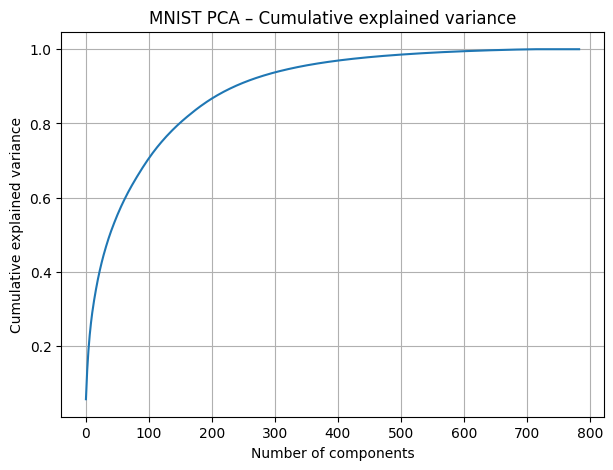

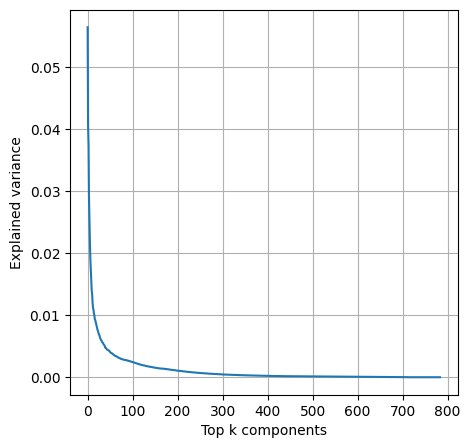

In [12]:
cum_var = np.cumsum(pca_full.explained_variance_ratio_)
plt.figure(figsize=(7,5))
plt.plot(cum_var)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("MNIST PCA – Cumulative explained variance")
plt.grid(True)
plt.show()

plt.figure(figsize=(5,5)) 
# plt.title('find elbow points')
plt.xlabel("Top k components")
plt.ylabel("Explained variance")
plt.plot(pca_full.explained_variance_ratio_)
plt.grid(True)
plt.show()

### Choose PCA dimensions

In [13]:
threshold = [0.8,0.9,0.95,0.99] # edit this
pca_dims = [1,2,3,20,50]
for thres in threshold:
    k = finddim(cum_var,thres)
    pca_dims.append(k)
    print(f"dims for {thres*100}%:", k)
pca_dims.append(784)
print(f'chosen dimensions: {pca_dims}')

dims for 80.0%: 150
dims for 90.0%: 238
dims for 95.0%: 332
dims for 99.0%: 544
chosen dimensions: [1, 2, 3, 20, 50, 150, 238, 332, 544, 784]


### Transform dataset into selected PCA spaces

In [14]:
x_mnist_pca = {}   
pca_models = {}    

for d in pca_dims:
    pca = PCA(n_components=d)
    x_mnist_pca[d] = pca.fit_transform(x_mnist)
    pca_models[d] = pca
    print(f"PCA dim={d}: shape={x_mnist_pca[d].shape}")

PCA dim=1: shape=(70000, 1)
PCA dim=2: shape=(70000, 2)
PCA dim=3: shape=(70000, 3)
PCA dim=20: shape=(70000, 20)
PCA dim=50: shape=(70000, 50)
PCA dim=150: shape=(70000, 150)
PCA dim=238: shape=(70000, 238)
PCA dim=332: shape=(70000, 332)
PCA dim=544: shape=(70000, 544)
PCA dim=784: shape=(70000, 784)


### Visualize Low Dimensional PCA

#### 2d

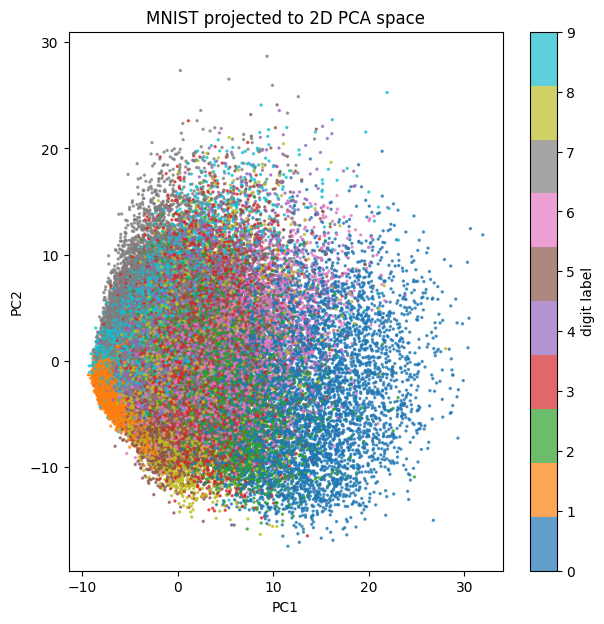

In [15]:
X2 = x_mnist_pca[2]
y = y_mnist.squeeze().astype(int)

plt.figure(figsize=(7,7))
plt.scatter(X2[:,0], X2[:,1],
            c=y, cmap="tab10",
            s=2, alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("MNIST projected to 2D PCA space")
plt.colorbar(label="digit label")
plt.show()

#### 3d

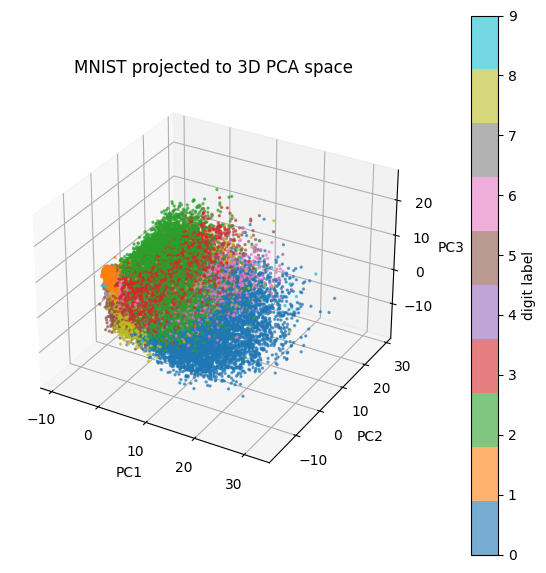

In [16]:
X3 = x_mnist_pca[3]
y = y_mnist.squeeze().astype(int)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X3[:, 0], X3[:, 1], X3[:, 2],
    c=y, cmap="tab10",
    s=2, alpha=0.6
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("MNIST projected to 3D PCA space")

cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label("digit label")

plt.show()

#### Selected top PCA eigenvectors visualization

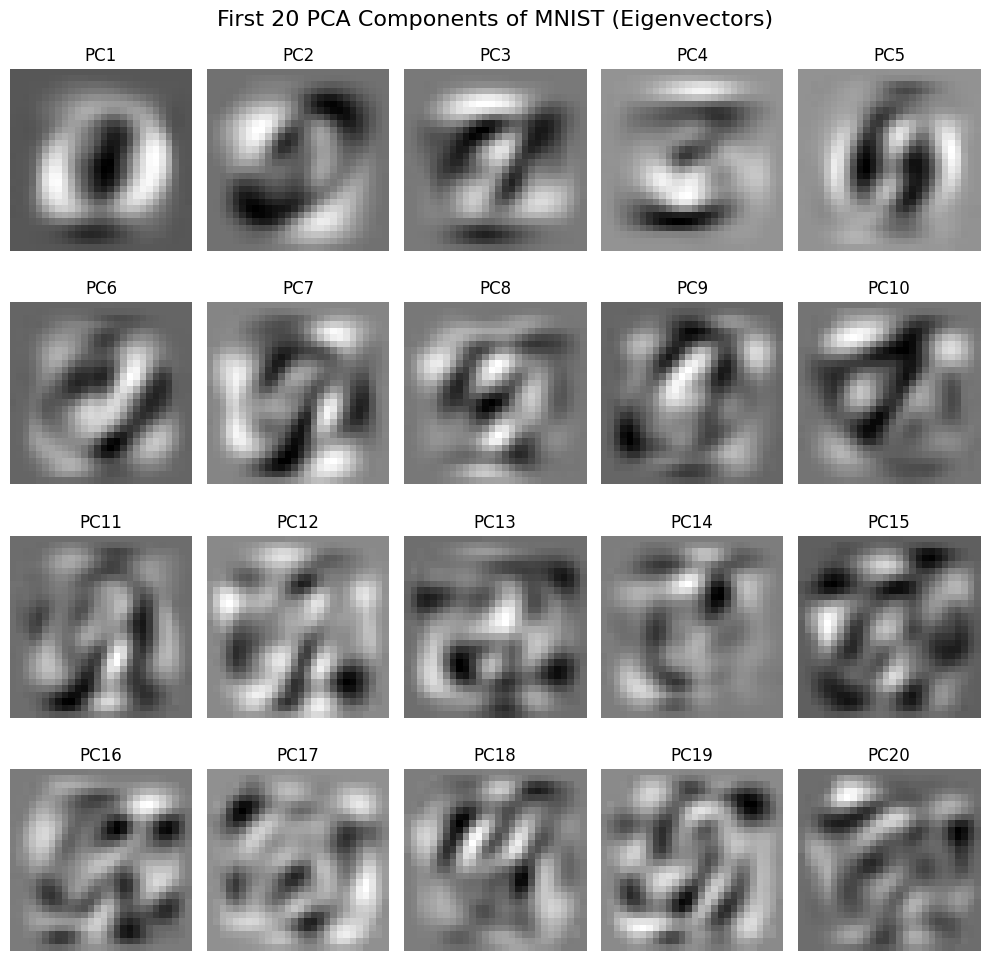

In [36]:
n_components_to_show = 20
components = pca_full.components_[:n_components_to_show]

plt.figure(figsize=(10,10))

for i in range(n_components_to_show):
    pc = components[i].reshape(28, 28)
    
    plt.subplot(int(n_components_to_show / 5), 5, i+1)
    plt.imshow(pc, cmap='gray')
    plt.title(f"PC{i+1}")
    plt.axis('off')

plt.suptitle("First 20 PCA Components of MNIST (Eigenvectors)", fontsize=16)
plt.tight_layout()
plt.show()

## 2.2 PCA for Covid

### Normalize data (already done)

### Compute Full PCA

In [18]:
pca_full_covid = PCA(n_components=x_covid.shape[1])
x_covid_pca_full = pca_full_covid.fit_transform(x_covid)
D_covid = pca_full_covid.explained_variance_
V_covid = pca_full_covid.components_.T

In [19]:
print(D_covid[:5])

[1.08717763 0.4128526  0.25114062 0.22486119 0.1625898 ]


### Plor Explained Variance 

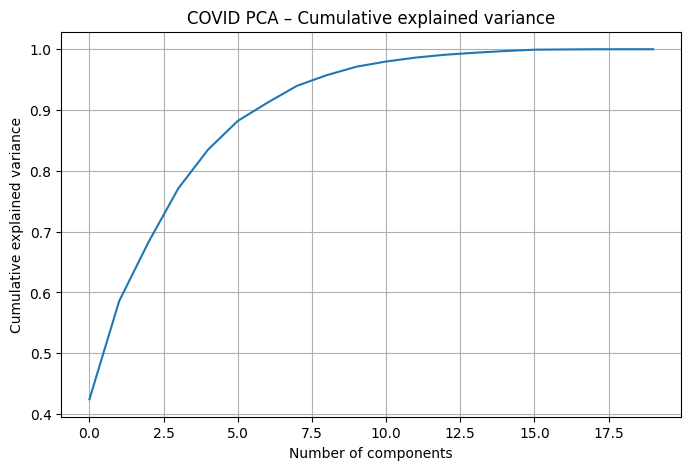

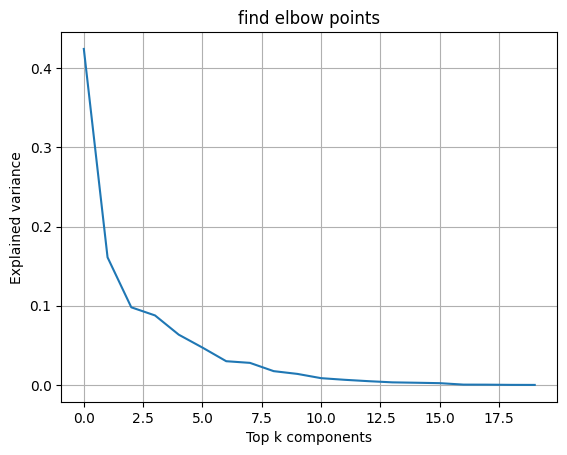

In [20]:
cum_var_covid = np.cumsum(pca_full_covid.explained_variance_ratio_)
plt.figure(figsize=(8,5))
plt.plot(cum_var_covid)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("COVID PCA – Cumulative explained variance")
plt.grid(True)
plt.show()

plt.figure() 
plt.title('find elbow points')
plt.xlabel("Top k components")
plt.ylabel("Explained variance")
plt.plot(pca_full_covid.explained_variance_ratio_)
plt.grid(True)
plt.show()

### Choose PCA Dimensions

In [21]:
threshold = [0.8,0.9,0.95,0.99] # edit this
pca_dims_covid=[1,2,3]
for thres in threshold:
    k = finddim(cum_var_covid,thres)
    pca_dims_covid.append(k)
    print(f"dims for {thres*100}%:", k)
pca_dims_covid.append(x_covid.shape[1])
print(f'chosen dimensions: {pca_dims_covid}')

dims for 80.0%: 5
dims for 90.0%: 7
dims for 95.0%: 9
dims for 99.0%: 13
chosen dimensions: [1, 2, 3, 5, 7, 9, 13, 20]


### Transform dataset into selected PCA spaces

In [22]:
x_covid_pca = {}   
pca_models_covid = {}    

for d in pca_dims_covid:
    pca = PCA(n_components=d)
    x_covid_pca[d] = pca.fit_transform(x_covid)
    pca_models_covid[d] = pca
    print(f"PCA dim={d}: shape={x_covid_pca[d].shape}")

PCA dim=1: shape=(1025152, 1)
PCA dim=2: shape=(1025152, 2)
PCA dim=3: shape=(1025152, 3)
PCA dim=5: shape=(1025152, 5)
PCA dim=7: shape=(1025152, 7)
PCA dim=9: shape=(1025152, 9)
PCA dim=13: shape=(1025152, 13)
PCA dim=20: shape=(1025152, 20)


### Visualize Low Dimensional PCA

#### 2d

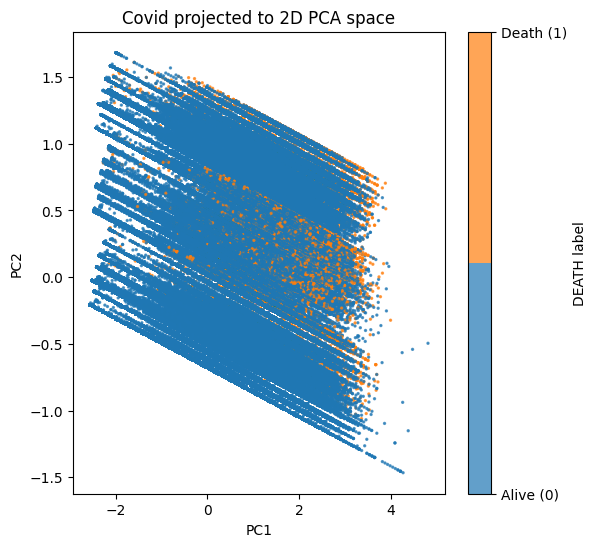

In [23]:
X2 = x_covid_pca[2]
y = y_covid.squeeze().astype(int)

cmap = ListedColormap(["tab:blue", "tab:orange"])
plt.figure(figsize=(6,6))
sc = plt.scatter(X2[:,0], X2[:,1],
            c=y, cmap=cmap,
            s=2, alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Covid projected to 2D PCA space")
cbar = plt.colorbar(sc, ticks=[0, 1])
cbar.ax.set_yticklabels(["Alive (0)", "Death (1)"])
cbar.set_label(label="DEATH label")
plt.show()

#### 3d

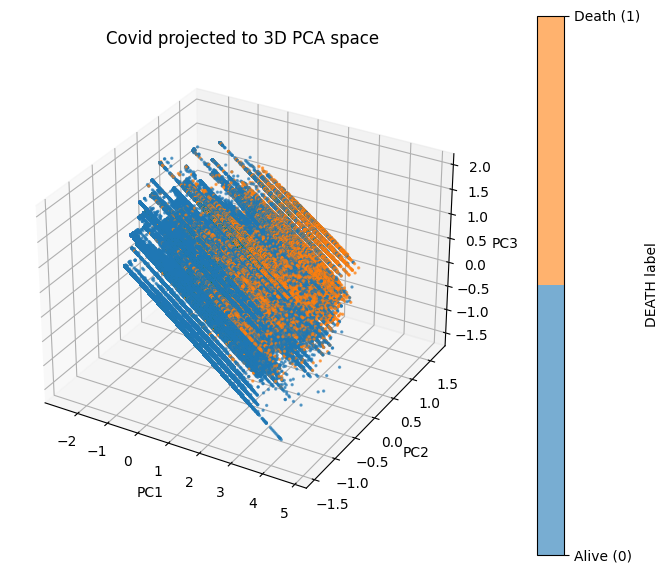

In [24]:
X3 = x_covid_pca[3]
y = y_covid.squeeze().astype(int)

cmap = ListedColormap(["tab:blue", "tab:orange"])

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111, projection='3d')

sc = scatter = ax.scatter(
    X3[:, 0], X3[:, 1], X3[:, 2],
    c=y, cmap=cmap,
    s=2, alpha=0.6
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Covid projected to 3D PCA space")

cbar = fig.colorbar(scatter, ax=ax, pad=0.1, ticks=[0, 1])
cbar.ax.set_yticklabels(["Alive (0)", "Death (1)"])
cbar.set_label("DEATH label")

plt.show()

# 3. Step 3: K-means Clustering under Different PCA Dimensions & Evaluate
To examine how the representation space (i.e., different PCA dimensions) affects the cluster structure discovered by K-means.
## SOP
- Define PCA dimensions to test (done in Step 2)
- Transform dataset to each PCA space (done in Step 2)
- Run K-means for k=10 and 2
- Compute metrics comparing clusters to labels
- Visualize cluster scatter plots for low dims
- Summarize results in a table

## 3.1 For MNIST

### Run K-means for k=10 & Compute metrics comparing clusters to labels

In [25]:
results = {
    "dim": [],
    "ACC": [],
    "NMI": [],
    "ARI": [],
    "inertia": []
}

# ===== baseline: 784-d raw data =====
kmeans_raw = KMeans(n_clusters=10, n_init="auto", random_state=seed)
clusters_raw = kmeans_raw.fit_predict(x_mnist)

acc_raw, nmi_raw, ari_raw = evaluate_kmeans(x_mnist, y_mnist.reshape(-1))

results["dim"].append(x_mnist.shape[1])
results["ACC"].append(acc_raw)
results["NMI"].append(nmi_raw)
results["ARI"].append(ari_raw)
results["inertia"].append(kmeans_raw.inertia_ / x_mnist.shape[0])

print("K-means on raw data:")
print(f"  ACC: {acc_raw:.4f}")
print(f"  NMI: {nmi_raw:.4f}")
print(f"  ARI: {ari_raw:.4f}")
print("  Intra Inertia:",
      kmeans_raw.inertia_ / x_mnist.shape[0])


K-means on raw data:
  ACC: 0.4876
  NMI: 0.4087
  ARI: 0.2938
  Intra Inertia: 608.9500030457099


In [26]:
for d in pca_dims:
    Xd = x_mnist_pca[d]          # (70000, d)
    
    kmeans_d = KMeans(n_clusters=10, n_init="auto", random_state=seed)
    clusters_d = kmeans_d.fit_predict(Xd)
    
    acc_d, nmi_d, ari_d = evaluate_kmeans(Xd, y_mnist.reshape(-1))
    inertia_d = kmeans_d.inertia_ / Xd.shape[0]
    
    results["dim"].append(d)
    results["ACC"].append(acc_d)
    results["NMI"].append(nmi_d)
    results["ARI"].append(ari_d)
    results["inertia"].append(inertia_d)
    
    print(f"\nK-means on PCA dim={d}:")
    print(f"  ACC: {acc_d:.4f}")
    print(f"  NMI: {nmi_d:.4f}")
    print(f"  ARI: {ari_d:.4f}")
    print(f"  Inertia per point: {inertia_d:.4f}")



K-means on PCA dim=1:
  ACC: 0.2599
  NMI: 0.1949
  ARI: 0.1192
  Inertia per point: 0.6734

K-means on PCA dim=2:
  ACC: 0.2991
  NMI: 0.2141
  ARI: 0.1415
  Inertia per point: 9.4793

K-means on PCA dim=3:
  ACC: 0.3711
  NMI: 0.3201
  ARI: 0.2166
  Inertia per point: 22.3621

K-means on PCA dim=20:
  ACC: 0.4959
  NMI: 0.4266
  ARI: 0.3171
  Inertia per point: 164.8083

K-means on PCA dim=50:
  ACC: 0.5000
  NMI: 0.4321
  ARI: 0.3227
  Inertia per point: 284.5046

K-means on PCA dim=150:
  ACC: 0.4956
  NMI: 0.4314
  ARI: 0.3219
  Inertia per point: 463.3103

K-means on PCA dim=238:
  ACC: 0.5026
  NMI: 0.4346
  ARI: 0.3241
  Inertia per point: 536.5627

K-means on PCA dim=332:
  ACC: 0.5026
  NMI: 0.4347
  ARI: 0.3242
  Inertia per point: 571.7978

K-means on PCA dim=544:
  ACC: 0.5026
  NMI: 0.4345
  ARI: 0.3240
  Inertia per point: 601.6415

K-means on PCA dim=784:
  ACC: 0.4876
  NMI: 0.4087
  ARI: 0.2938
  Inertia per point: 609.2899


### Visualize cluster scatter plots for low dims

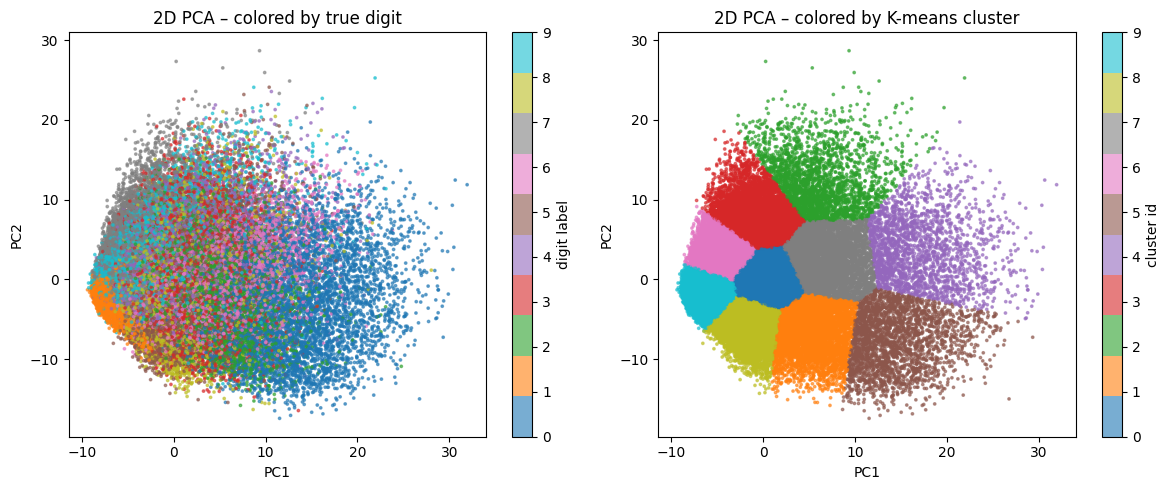

In [27]:
X2 = x_mnist_pca[2]
PCA_model2 = pca_models[2]
y_true = y_mnist.squeeze().astype(int)
kmeans_d2 = KMeans(n_clusters=10, n_init="auto", random_state=seed)
clusters_d2 = kmeans_d2.fit_predict(X2)
y_cluster = clusters_d2.astype(int)

plt.figure(figsize=(12,5))

# ---- Left: true label ----
plt.subplot(1,2,1)
sc1 = plt.scatter(X2[:,0], X2[:,1],
                  c=y_true, cmap="tab10", s=3, alpha=0.6)
plt.title("2D PCA – colored by true digit")
plt.xlabel("PC1")
plt.ylabel("PC2")
cbar1 = plt.colorbar(sc1)
cbar1.set_label("digit label")

# ---- Right: K-means cluster ----
plt.subplot(1,2,2)
sc2 = plt.scatter(X2[:,0], X2[:,1],
                  c=y_cluster, cmap="tab10", s=3, alpha=0.6)
plt.title("2D PCA – colored by K-means cluster")
plt.xlabel("PC1")
plt.ylabel("PC2")
cbar2 = plt.colorbar(sc2)
cbar2.set_label("cluster id")

plt.tight_layout()
plt.show()


## 3.2 Covid dataset

### Run K-means for k=10 & Compute metrics comparing clusters to labels

In [28]:
results_covid = {
    "dim": [],
    "ACC": [],
    "NMI": [],
    "ARI": [],
    "inertia": []
}

# ===== baseline: 20-d raw data =====
kmeans_raw_covid = KMeans(n_clusters=2, n_init="auto", random_state=seed)
clusters_raw_covid = kmeans_raw_covid.fit_predict(x_covid)

acc_raw, nmi_raw, ari_raw = evaluate_kmeans(x_covid, y_covid.reshape(-1))

results_covid["dim"].append(x_covid.shape[1])
results_covid["ACC"].append(acc_raw)
results_covid["NMI"].append(nmi_raw)
results_covid["ARI"].append(ari_raw)
results_covid["inertia"].append(kmeans_raw_covid.inertia_ / x_covid.shape[0])

print("K-means on raw data:")
print(f"  ACC: {acc_raw:.4f}")
print(f"  NMI: {nmi_raw:.4f}")
print(f"  ARI: {ari_raw:.4f}")
print("  Intra Inertia:",
      kmeans_raw_covid.inertia_ / x_covid.shape[0])


K-means on raw data:
  ACC: 0.2122
  NMI: 0.0826
  ARI: 0.0202
  Intra Inertia: 1.8532560570871028


In [29]:
for d in pca_dims_covid:
    Xd = x_covid_pca[d]          # (samples, d)
    
    kmeans_d = KMeans(n_clusters=2, n_init="auto", random_state=seed)
    clusters_d = kmeans_d.fit_predict(Xd)
    
    acc_d, nmi_d, ari_d= evaluate_kmeans(Xd, y_covid.reshape(-1))
    inertia_d = kmeans_d.inertia_ / Xd.shape[0]
    
    results_covid["dim"].append(d)
    results_covid["ACC"].append(acc_d)
    results_covid["NMI"].append(nmi_d)
    results_covid["ARI"].append(ari_d)
    results_covid["inertia"].append(inertia_d)
    
    print(f"\nK-means on PCA dim={d}:")
    print(f"  ACC: {acc_d:.4f}")
    print(f"  NMI: {nmi_d:.4f}")
    print(f"  ARI: {ari_d:.4f}")
    print(f"  Inertia per point: {inertia_d:.4f}")



K-means on PCA dim=1:
  ACC: 0.1817
  NMI: 0.0606
  ARI: 0.0201
  Inertia per point: 0.3801

K-means on PCA dim=2:
  ACC: 0.1997
  NMI: 0.0619
  ARI: 0.0211
  Inertia per point: 0.7925

K-means on PCA dim=3:
  ACC: 0.1957
  NMI: 0.0747
  ARI: 0.0218
  Inertia per point: 1.0435

K-means on PCA dim=5:
  ACC: 0.1789
  NMI: 0.0763
  ARI: 0.0159
  Inertia per point: 1.4307

K-means on PCA dim=7:
  ACC: 0.1753
  NMI: 0.0835
  ARI: 0.0182
  Inertia per point: 1.6281

K-means on PCA dim=9:
  ACC: 0.1807
  NMI: 0.0838
  ARI: 0.0192
  Inertia per point: 1.7441

K-means on PCA dim=13:
  ACC: 0.1987
  NMI: 0.0842
  ARI: 0.0209
  Inertia per point: 1.8303

K-means on PCA dim=20:
  ACC: 0.2122
  NMI: 0.0826
  ARI: 0.0202
  Inertia per point: 1.8534


### Visualize cluster scatter plots for low dims

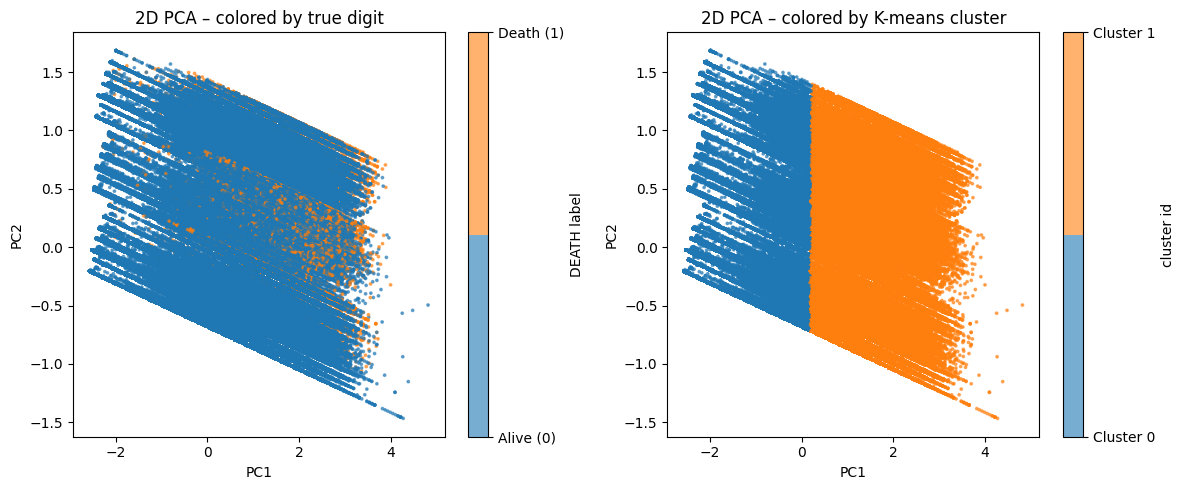

In [30]:
X2 = x_covid_pca[2]
PCA_model2 = pca_models_covid[2]
y_true = y_covid.squeeze().astype(int)
kmeans_pca2 = KMeans(n_clusters=2, n_init="auto", random_state=seed)
y_cluster = kmeans_pca2.fit_predict(X2)

plt.figure(figsize=(12,5))

cmap2 = ListedColormap(["tab:blue", "tab:orange"])
# ---- Left: true label ----
plt.subplot(1,2,1)
sc1 = plt.scatter(X2[:,0], X2[:,1],
                  c=y_true, cmap=cmap2, s=3, alpha=0.6)
plt.title("2D PCA – colored by true digit")
plt.xlabel("PC1")
plt.ylabel("PC2")
cbar1 = plt.colorbar(sc1)
cbar1.set_ticks([0,1])
cbar1.set_ticklabels(["Alive (0)", "Death (1)"])
cbar1.set_label("DEATH label")

# ---- Right: K-means cluster ----
plt.subplot(1,2,2)
sc2 = plt.scatter(X2[:,0], X2[:,1],
                  c=y_cluster, cmap=cmap2, s=3, alpha=0.6)
plt.title("2D PCA – colored by K-means cluster")
plt.xlabel("PC1")
plt.ylabel("PC2")
cbar2 = plt.colorbar(sc2)
cbar2.set_ticks([0,1])
cbar2.set_ticklabels(["Cluster 0", "Cluster 1"])
cbar2.set_label("cluster id")

plt.tight_layout()
plt.show()


# 4. Compare with SVM

# 4.1 SVM for MNIST 

### Train/Test Split

In [31]:
X = x_mnist               
y = y_mnist

indices = np.arange(len(X))

train_idx, test_idx = train_test_split(
    indices,
    test_size=0.2,
    random_state=seed,
    stratify=y,
)

X_train = X[train_idx]
X_test = X[test_idx]
y_train = y[train_idx]
y_test = y[test_idx]

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)
y_train = y_train.ravel()
y_test = y_test.ravel()
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (56000, 784) (56000, 1)
Test shape: (14000, 784) (14000, 1)
Train shape: (56000, 784) (56000,)
Test shape: (14000, 784) (14000,)


### Train and Test

In [32]:
pca_dims_for_svm = pca_dims

svm_pca_results = {}

y_train_flat = y_train.ravel()
y_test_flat = y_test.ravel()

for d in pca_dims_for_svm:
    print(f"\n=== SVM on PCA dim = {d} ===")
    
    Xd = x_mnist_pca[d]

    X_train_d = Xd[train_idx]
    X_test_d  = Xd[test_idx]

    # svm = LinearSVC(C=1.0, max_iter=300, dual=False, random_state=seed)
    # svm.fit(X_train_d, y_train_flat)
    svm = SGDClassifier(
        loss='hinge',      
        alpha=1e-4,        
        max_iter=1000,       
        tol=1e-3,
        random_state=seed,
        n_jobs=-1          
    )
    svm.fit(X_train_d, y_train_flat)
    y_pred = svm.predict(X_test_d)
    acc = accuracy_score(y_test_flat, y_pred)
    svm_pca_results[d] = acc

    print(f"Test ACC with PCA dim={d}: {acc:.4f}")

print("\nSummary (SVM on PCA features):")
for d, acc in svm_pca_results.items():
    print(f"  dim={d:3d}  ACC={acc:.4f}")



=== SVM on PCA dim = 1 ===
Test ACC with PCA dim=1: 0.2331

=== SVM on PCA dim = 2 ===
Test ACC with PCA dim=2: 0.3002

=== SVM on PCA dim = 3 ===
Test ACC with PCA dim=3: 0.4041

=== SVM on PCA dim = 20 ===
Test ACC with PCA dim=20: 0.8064

=== SVM on PCA dim = 50 ===
Test ACC with PCA dim=50: 0.8411

=== SVM on PCA dim = 150 ===
Test ACC with PCA dim=150: 0.8822

=== SVM on PCA dim = 238 ===
Test ACC with PCA dim=238: 0.8976

=== SVM on PCA dim = 332 ===
Test ACC with PCA dim=332: 0.9036

=== SVM on PCA dim = 544 ===
Test ACC with PCA dim=544: 0.8979

=== SVM on PCA dim = 784 ===
Test ACC with PCA dim=784: 0.8969

Summary (SVM on PCA features):
  dim=  1  ACC=0.2331
  dim=  2  ACC=0.3002
  dim=  3  ACC=0.4041
  dim= 20  ACC=0.8064
  dim= 50  ACC=0.8411
  dim=150  ACC=0.8822
  dim=238  ACC=0.8976
  dim=332  ACC=0.9036
  dim=544  ACC=0.8979
  dim=784  ACC=0.8969


## 4.2 SVM for Covid

### Train/Test Split

In [33]:
X = x_covid           
y = y_covid

indices = np.arange(len(X))
# print(len(indices))
train_idx, test_idx = train_test_split(
    indices,
    test_size=0.2,
    random_state=seed,
    stratify=y,
)
# print(len(train_idx))
X_train = X[train_idx]
X_test = X[test_idx]
y_train = y[train_idx]
y_test = y[test_idx]

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)
y_train = y_train.ravel()
y_test = y_test.ravel()
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (820121, 20) (820121,)
Test shape: (205031, 20) (205031,)
Train shape: (820121, 20) (820121,)
Test shape: (205031, 20) (205031,)


### Train and Test 

In [34]:
pca_dims_for_svm = pca_dims_covid

svm_pca_results = {}

y_train_flat = y_train.ravel()
y_test_flat = y_test.ravel()

for d in pca_dims_for_svm:
    print(f"\n=== SVM on PCA dim = {d} ===")
    
    Xd = x_covid_pca[d]

    X_train_d = Xd[train_idx]
    X_test_d  = Xd[test_idx]

    # svm = LinearSVC(C=1.0, max_iter=300, dual=False, random_state=seed)
    # svm.fit(X_train_d, y_train_flat)
    svm = SGDClassifier(
        loss='hinge',      
        alpha=1e-4,        
        max_iter=1000,       
        tol=1e-3,
        random_state=seed,
        n_jobs=-1,
        class_weight='balanced'         
    )
    svm.fit(X_train_d, y_train_flat)
    y_pred = svm.predict(X_test_d)
    acc = accuracy_score(y_test_flat, y_pred)
    svm_pca_results[d] = acc

    print(f"Test ACC with PCA dim={d}: {acc:.4f}")

print("\nSummary (SVM on PCA features):")
for d, acc in svm_pca_results.items():
    print(f"  dim={d:3d}  ACC={acc:.4f}")


=== SVM on PCA dim = 1 ===
Test ACC with PCA dim=1: 0.8014

=== SVM on PCA dim = 2 ===
Test ACC with PCA dim=2: 0.8443

=== SVM on PCA dim = 3 ===
Test ACC with PCA dim=3: 0.8538

=== SVM on PCA dim = 5 ===
Test ACC with PCA dim=5: 0.8842

=== SVM on PCA dim = 7 ===
Test ACC with PCA dim=7: 0.8806

=== SVM on PCA dim = 9 ===
Test ACC with PCA dim=9: 0.8730

=== SVM on PCA dim = 13 ===
Test ACC with PCA dim=13: 0.8730

=== SVM on PCA dim = 20 ===
Test ACC with PCA dim=20: 0.8730

Summary (SVM on PCA features):
  dim=  1  ACC=0.8014
  dim=  2  ACC=0.8443
  dim=  3  ACC=0.8538
  dim=  5  ACC=0.8842
  dim=  7  ACC=0.8806
  dim=  9  ACC=0.8730
  dim= 13  ACC=0.8730
  dim= 20  ACC=0.8730
